In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msgn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from missingpy import MissForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import json
%matplotlib inline

In [2]:
with open('H:\\RA job\\configs\\config2.json') as json_file:
    config = json.load(json_file)

In [3]:
df = pd.read_csv(config['input_file'])

In [4]:
df.shape

(113371, 13)

### Check the proportion of missing values in the  original dataset 

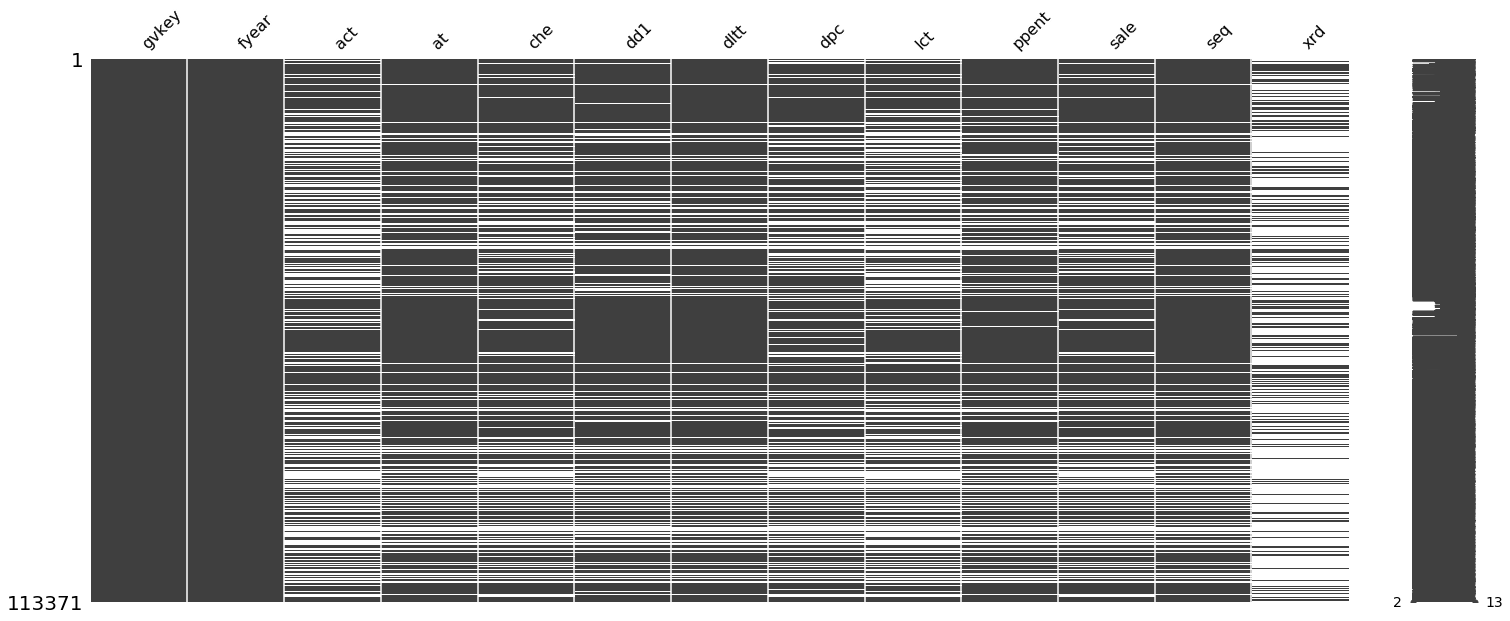

In [5]:
msgn.matrix(df)

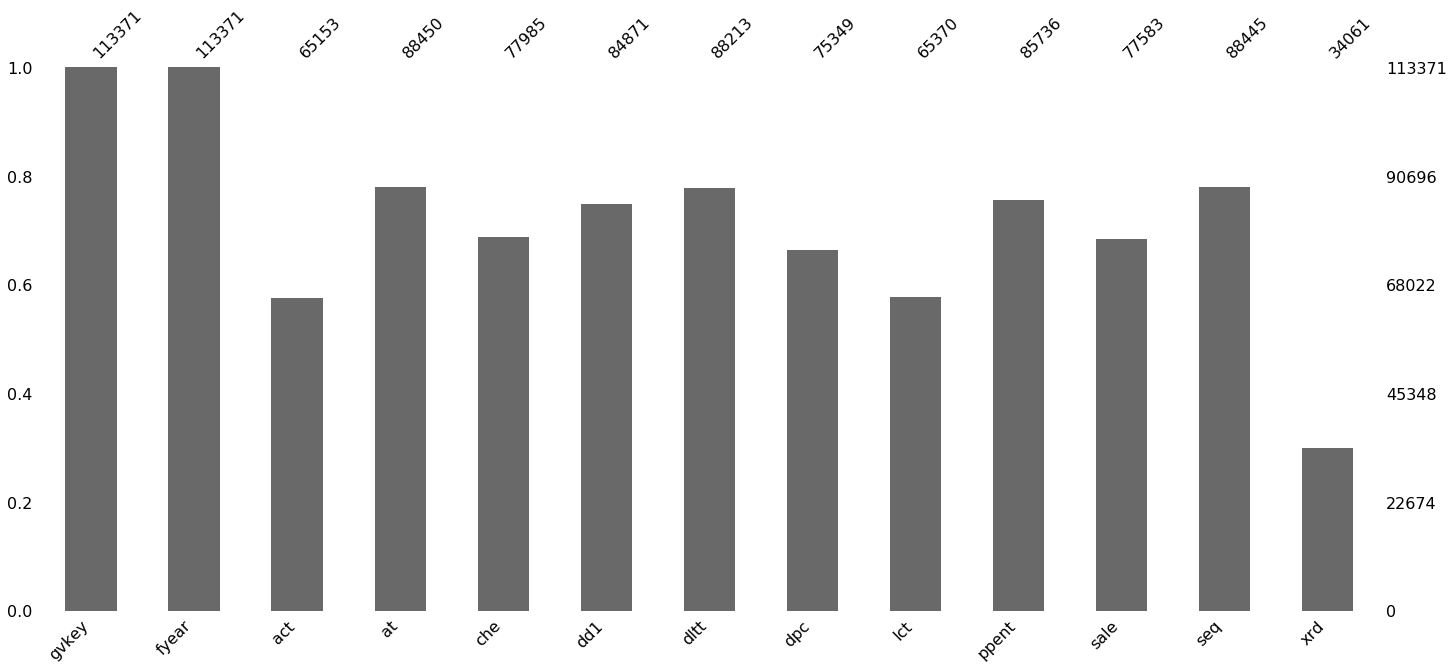

In [6]:
msgn.bar(df)

### Filter rows that have all columns missing

In [7]:
df = df.dropna(how='all')

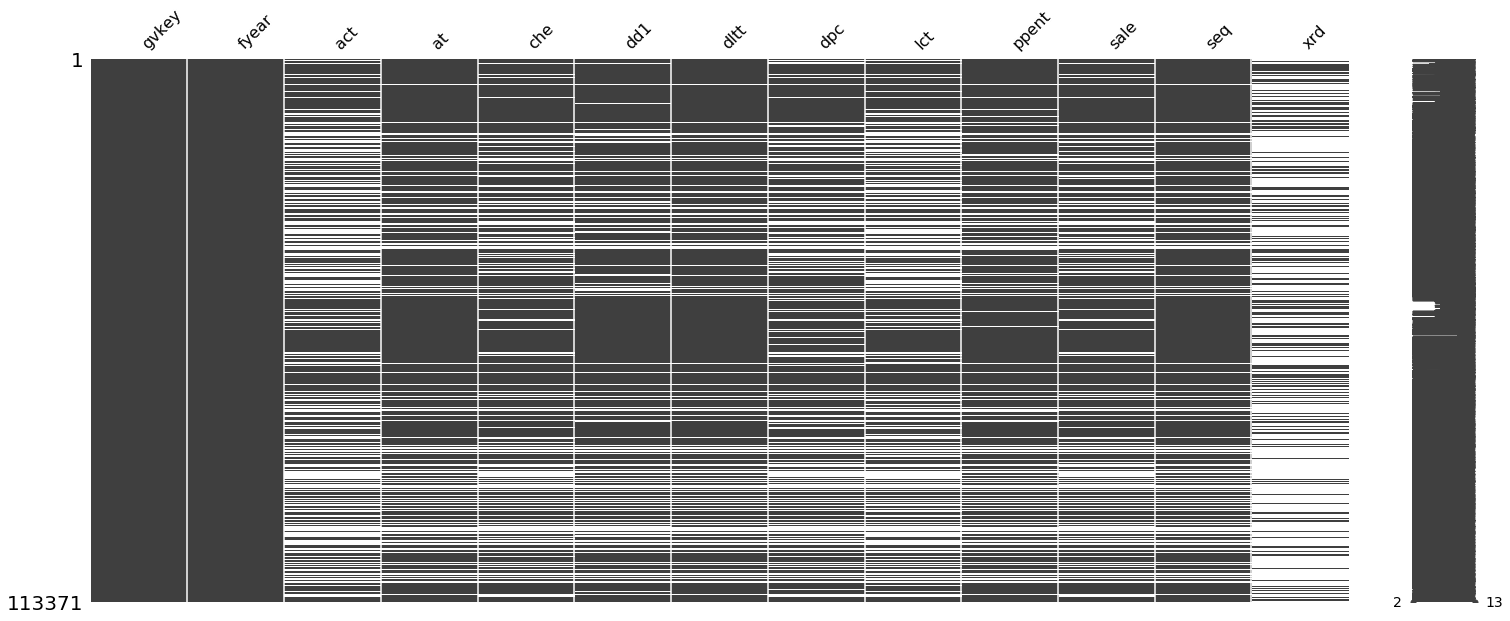

In [8]:
msgn.matrix(df)

### Find which columns have more than 75% data missing

In [9]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

In [10]:
subset = list(missing_value_df.column_name[missing_value_df.percent_missing > 75])

### Filter out the variables with more than 75% data missing

In [11]:
df1 = df.drop(subset,axis=1)

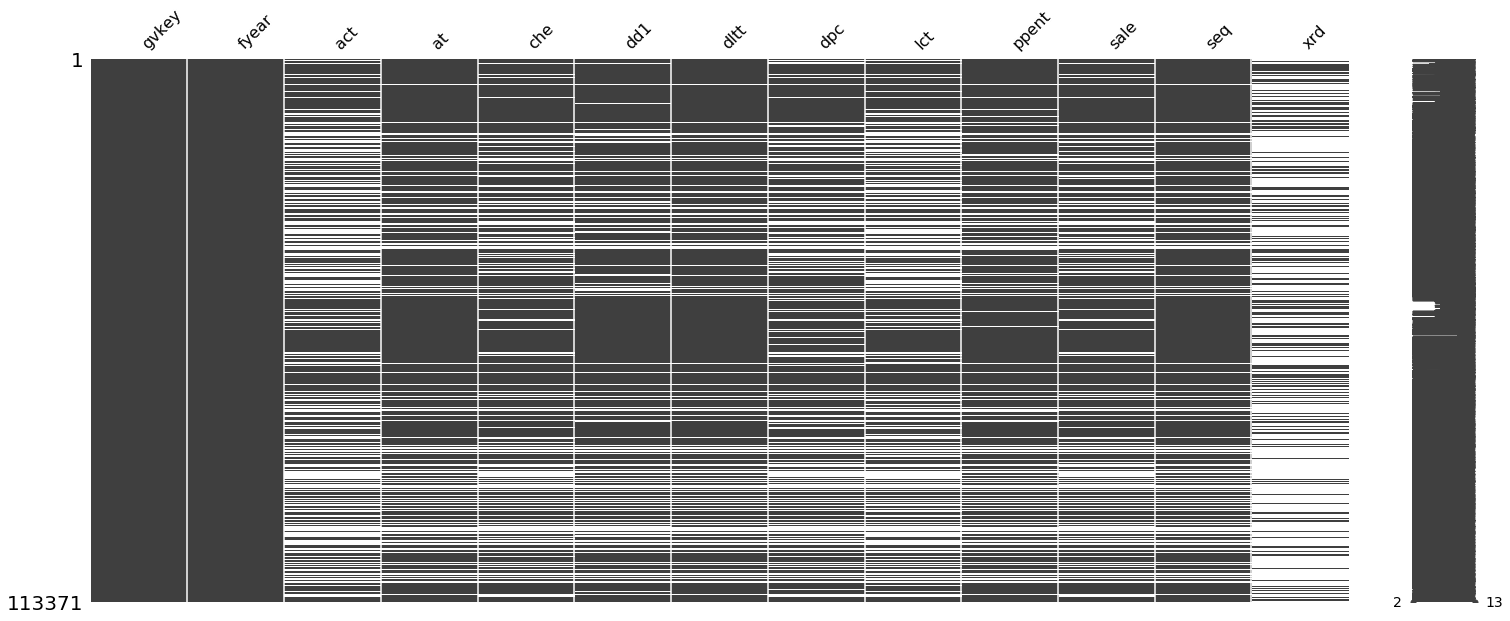

In [12]:
msgn.matrix(df1)

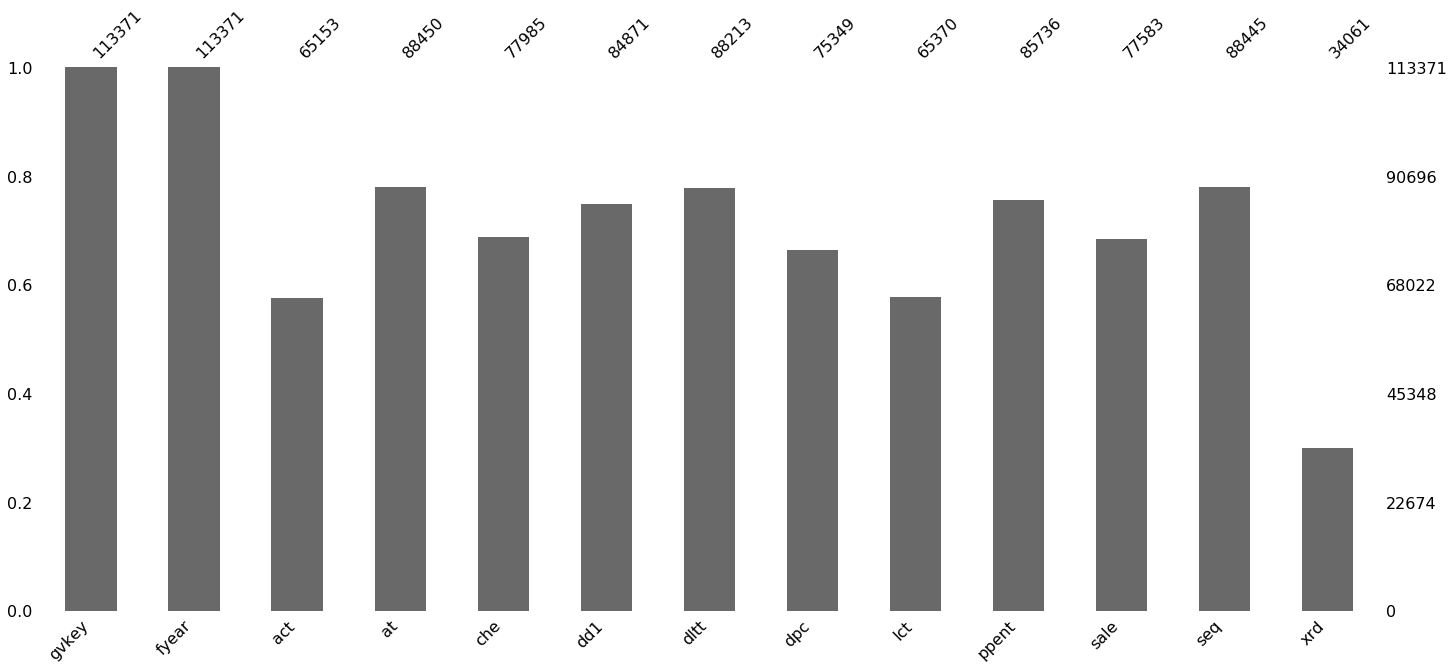

In [13]:
msgn.bar(df1)

### Step 1: Use random forest imputations on the independent variables which are needed to impute the dependent variables

In [14]:
#You can keep all the values at default but it takes a long time to impute the missing values.

from missingpy import MissForest
imputer = MissForest(max_iter=10, decreasing=False, missing_values=np.nan,
             copy=True, n_estimators=20, criterion=('mse', 'gini'),
             max_depth=None, min_samples_split=2, min_samples_leaf=1,
             min_weight_fraction_leaf=0.0, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             bootstrap=True, oob_score=False, n_jobs=-1, random_state=None,
             verbose=0, warm_start=False, class_weight=None)

In [15]:
%%time
##The variables selected here are only the independent ones required to impute the dependent variables
df2 = imputer.fit_transform(df1[config['step1']])
##The code returns a 2-D array which needs to be placed into our dataframe

Iteration: 0
Iteration: 1
Wall time: 13.8 s


In [16]:
## Create a copy of the dataframe so that the original one is not altred
df3 = df1

In [17]:
## The imputations will happen in the new dataframe
df3[config['step1']] = pd.DataFrame(df2)

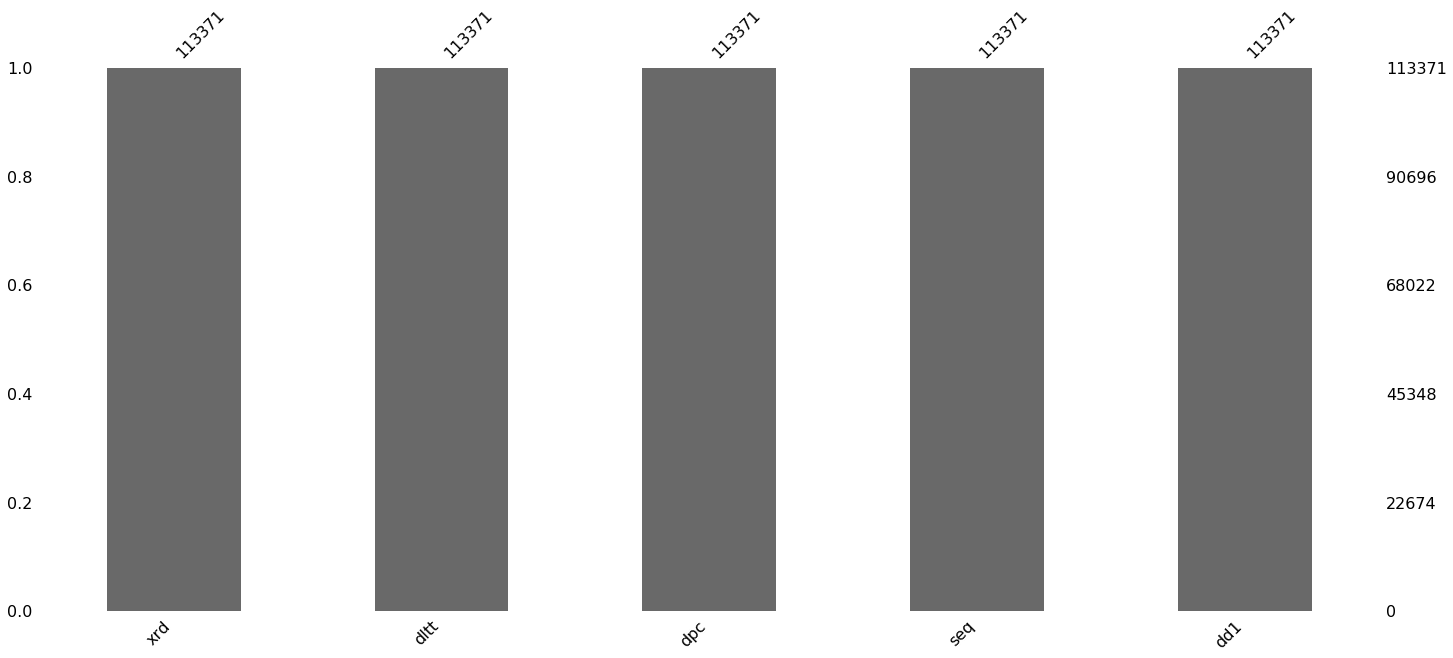

In [18]:
msgn.bar(df3[config['step1']])

### Use the imputed variables to build models for the dependent variables

In [19]:
for i in config['step2']:
    y = df3[i[0]][df3[i[0]].notnull()]
    x = np.array(df3[i[1:]])
    X = x[df3[i[0]].notnull()]
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
    reg = LinearRegression().fit(x_train, y_train.values.reshape(-1,1))
    
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    
    if reg.score(x_test,y_test.values.reshape(-1,1)) > regr.score(x_test, y_test):
        pred = pd.DataFrame(reg.predict(x),columns=['pred'])
    else:
        pred = pd.DataFrame(regr.predict(x),columns=['pred'])
    
    df3[i[0]] = df3[i[0]].fillna(pred.pred)

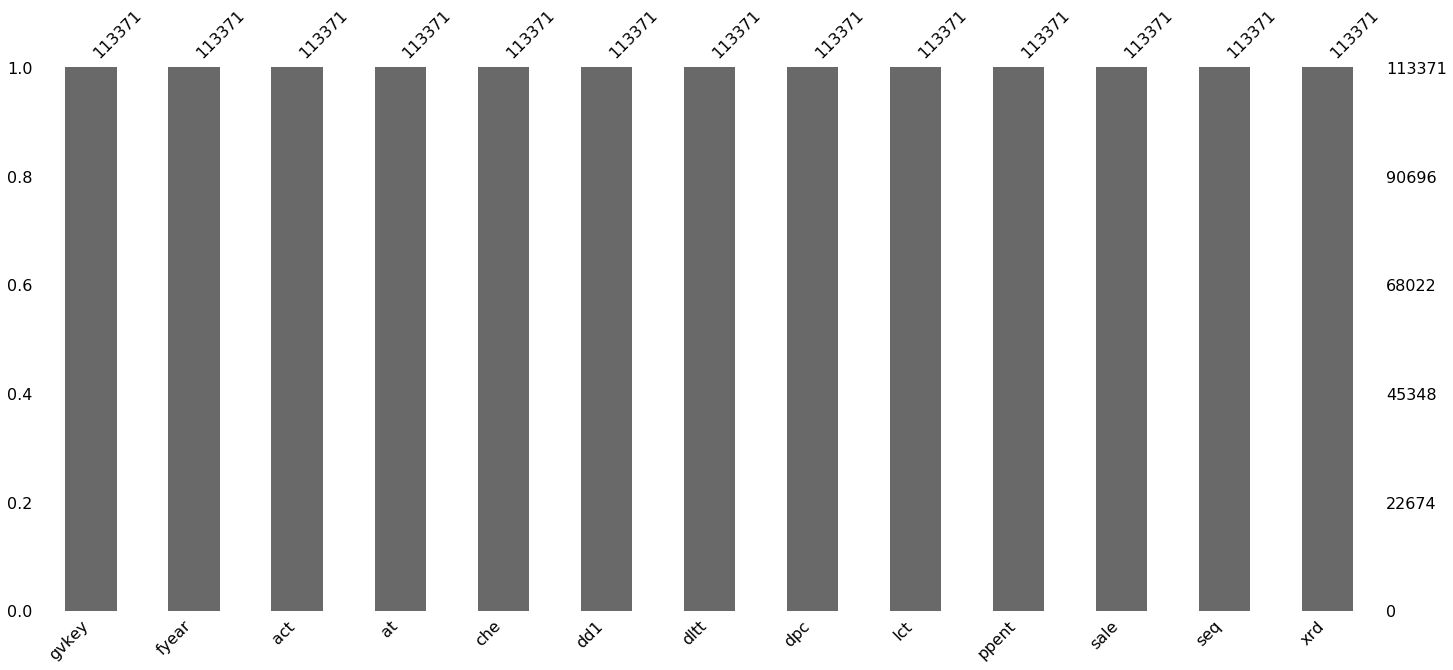

In [20]:
msgn.bar(df3)

In [21]:
%%time
df2 = imputer.fit_transform(df3.select_dtypes(include='float'))

Wall time: 60.9 ms


C:\ProgramData\Anaconda3\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


In [22]:
df3[df3.select_dtypes(include='float').columns] = pd.DataFrame(df2)

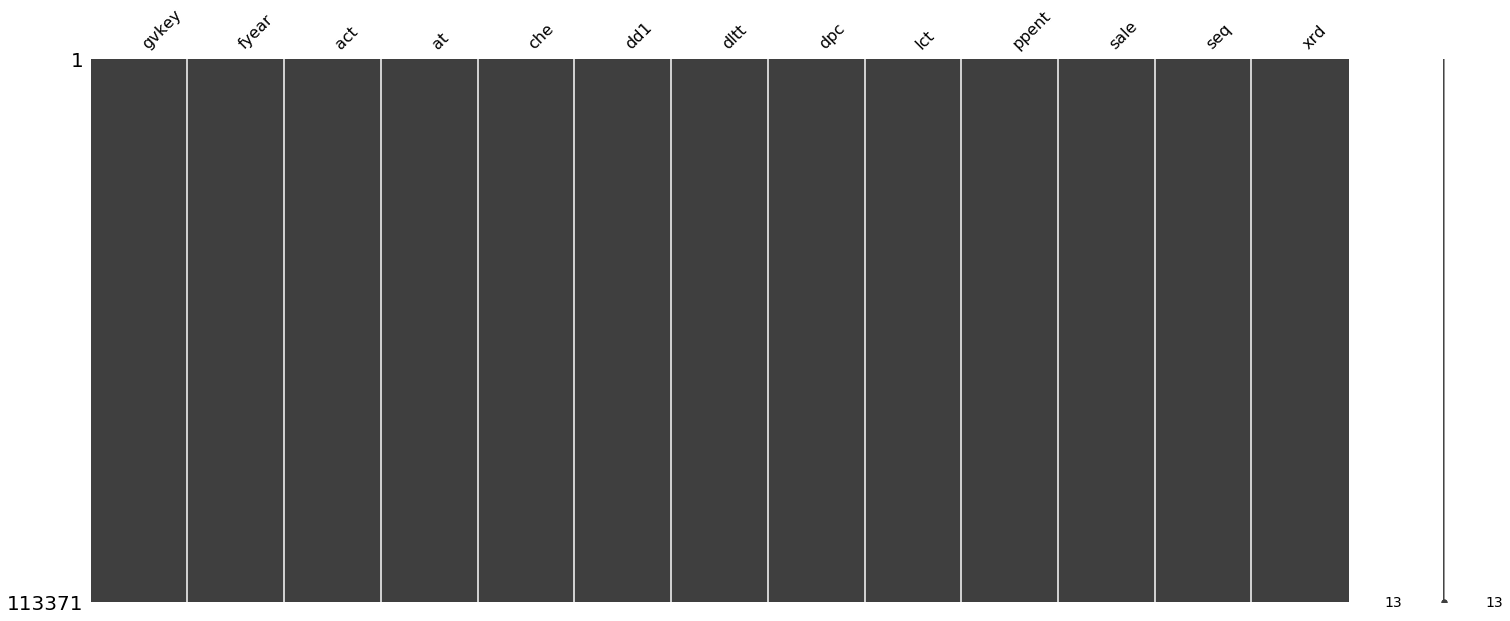

In [23]:
msgn.matrix(df3)

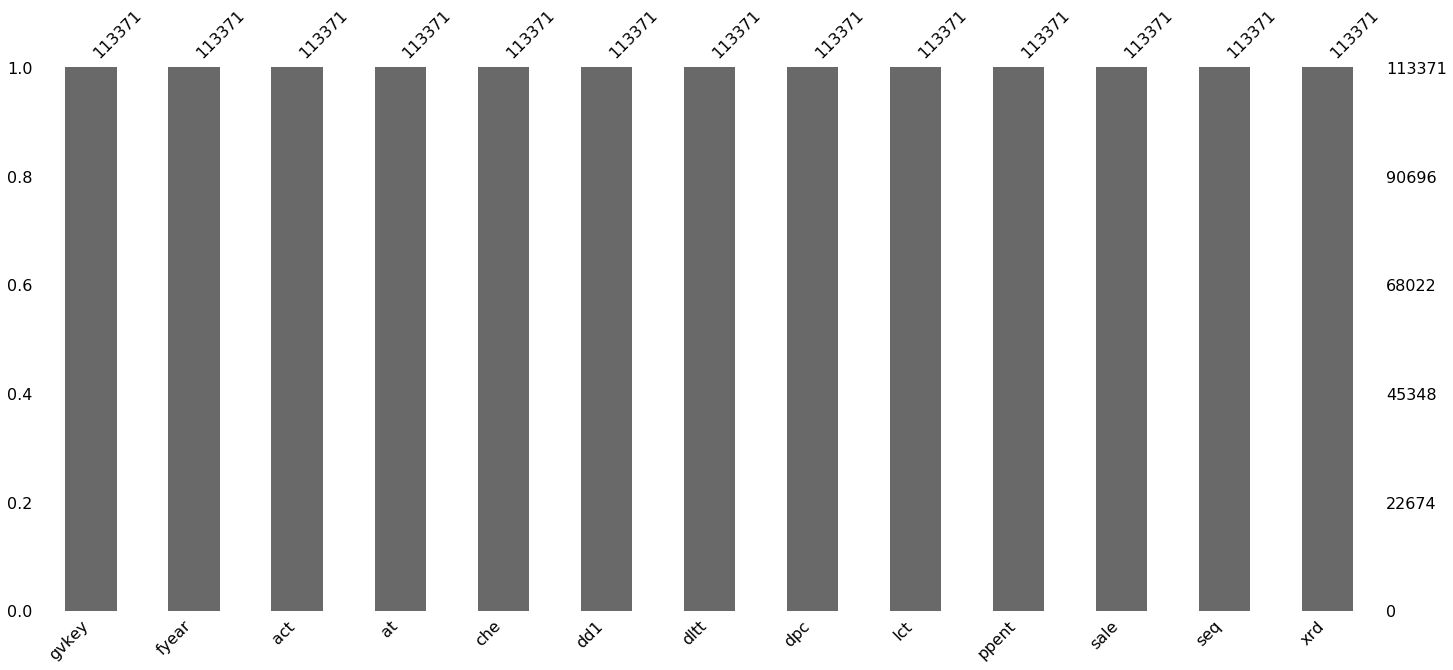

In [24]:
msgn.bar(df3)

In [25]:
percent_missing = df3.isnull().sum() * 100 / len(df3)
missing_value_df = pd.DataFrame({'column_name': df3.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
gvkey,gvkey,0.0
fyear,fyear,0.0
act,act,0.0
at,at,0.0
che,che,0.0
dd1,dd1,0.0
dltt,dltt,0.0
dpc,dpc,0.0
lct,lct,0.0
ppent,ppent,0.0


In [26]:
df3.to_csv(config["output_file"],index=False)